In [2]:
from matplotlib import pyplot as plt
import platform, os, sys, h5py
import numpy as np
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from tqdm import tqdm

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import import_data, artificial_anneal as anneal

%matplotlib inline
%config InlineBackend.figure_format='retina'

Could not import BEM module. Please do so manually.


Fit function: y = a0 + a1*x**2 + a2*x**4 + ...
===========  ===================  ======================
Parameter           Value                  Std
===========  ===================  ======================
a0           -0.6838525429164204  2.017895933832112e-05
a1           0.05551757829647165  0.00022614985828969277
a2           0.07826081584469018  0.00045255676307841264
===========  ===================  ======================
f = 22.239 +/- -0.045 GHz


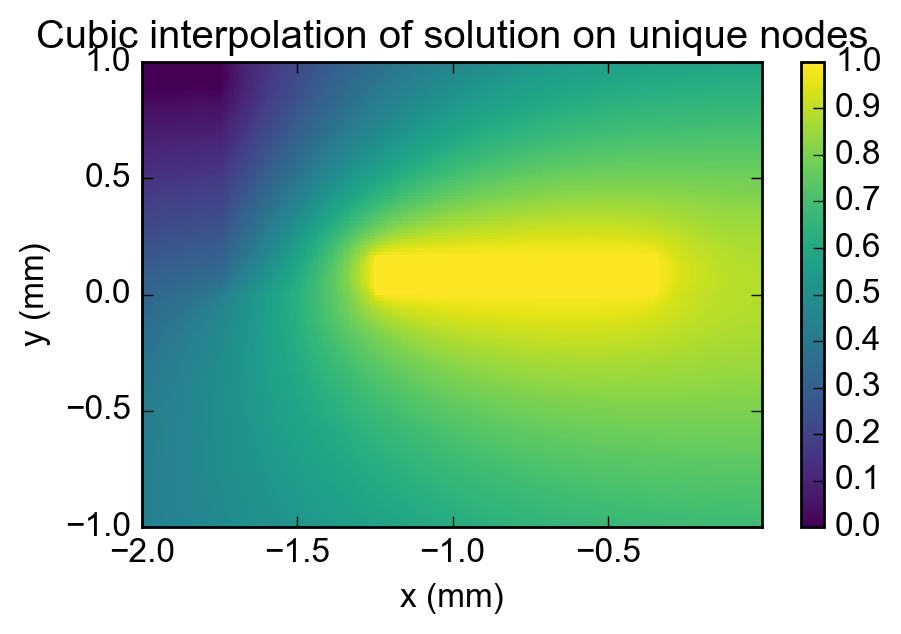

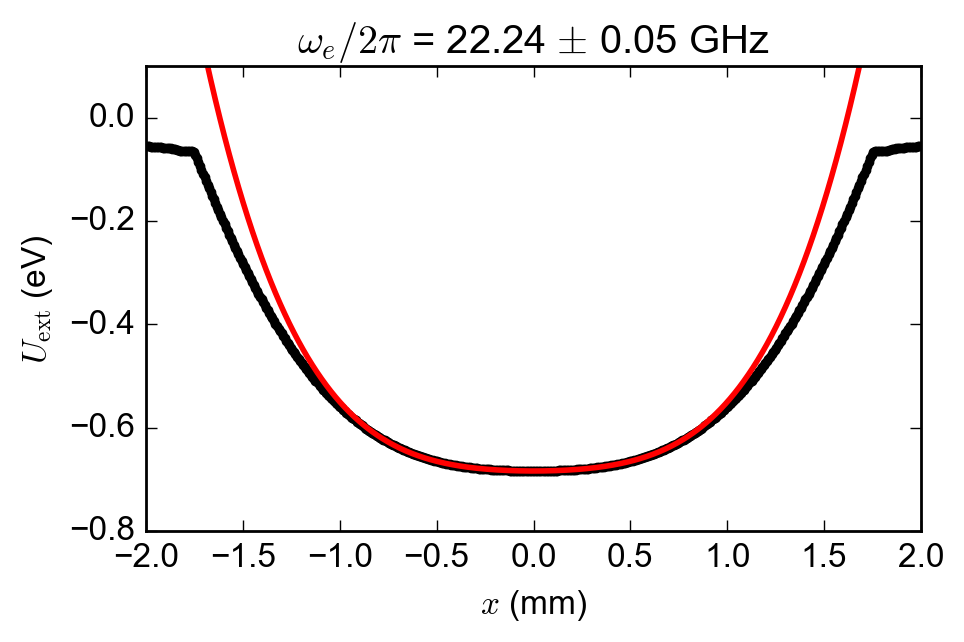

In [6]:
h = 0.75
fitdomain = (-0.75, 0.75)

# Load the data from the dsp file:
path = r'/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/M018V4/DCBiasPotential.dsp'
elements, nodes, elem_solution, bounding_box = import_data.load_dsp(path)

xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)

x0 = -2.0 # Starting point for y
k = 251 # This defines the sampling
xeval = anneal.construct_symmetric_y(x0, k)

fig0 = plt.figure(figsize=(5.,3.))
xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=xeval,
                                                     yeval=np.linspace(-1,1,151), clim=(0.00, 1.00), plot_axes='xy', linestyle='None',
                                                     cmap=plt.cm.viridis, plot_data=True,
                                                     **common.plot_opt("darkorange", msize=6))

xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=xeval,
                                                              yeval=h, clim=(0.00, 1.00),
                                                              plot_axes='xy', linestyle='None',
                                                              cmap=plt.cm.viridis, plot_data=False,
                                                              **common.plot_opt("darkorange", msize=6))

# Mirror around the y-axis
xsize = len(Uinterp[0])
Uinterp_symmetric = np.zeros(2*xsize)
Uinterp_symmetric[:xsize] = Uinterp[0]
Uinterp_symmetric[xsize:] = Uinterp[0][::-1]

x_symmetric = np.zeros(2 * xsize)
x_symmetric[:xsize] = xinterp[0]
x_symmetric[xsize:] = -xinterp[0][::-1]

fig1 = plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(x_symmetric, -Uinterp_symmetric, '.k')
plt.ylim(-0.8, 0.1)
plt.xlim(-2, 2)
plt.ylabel("$U_{\mathrm{ext}}$ (eV)")
plt.xlabel("$x$ (mm)")

ax = plt.gca()
ax.set_axis_bgcolor('none')
fr, ferr = kfit.fit_poly(x_symmetric, -Uinterp_symmetric, mode='even', fitparams=[0, 1E4, 1E4], domain=fitdomain)
plt.plot(x_symmetric, kfit.polyfunc_even(x_symmetric, *fr), color='r', lw=2.0)

t = trap_analysis.TrapSolver()
f, sigmaf = t.get_electron_frequency([fr[0], -fr[1]], [ferr[0], -ferr[1]])
plt.title(r"$\omega_e/2\pi$ = %.2f $\pm$ %.2f GHz"%(f/1E9, np.abs(sigmaf)/1E9))

Resonator data was inserted from x = 7.88 um to x = 17.84 um


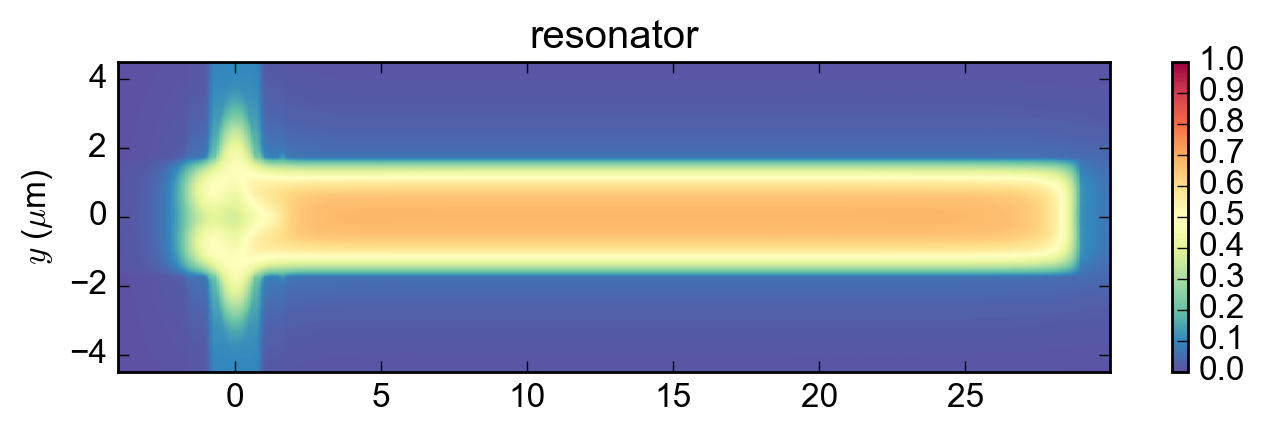

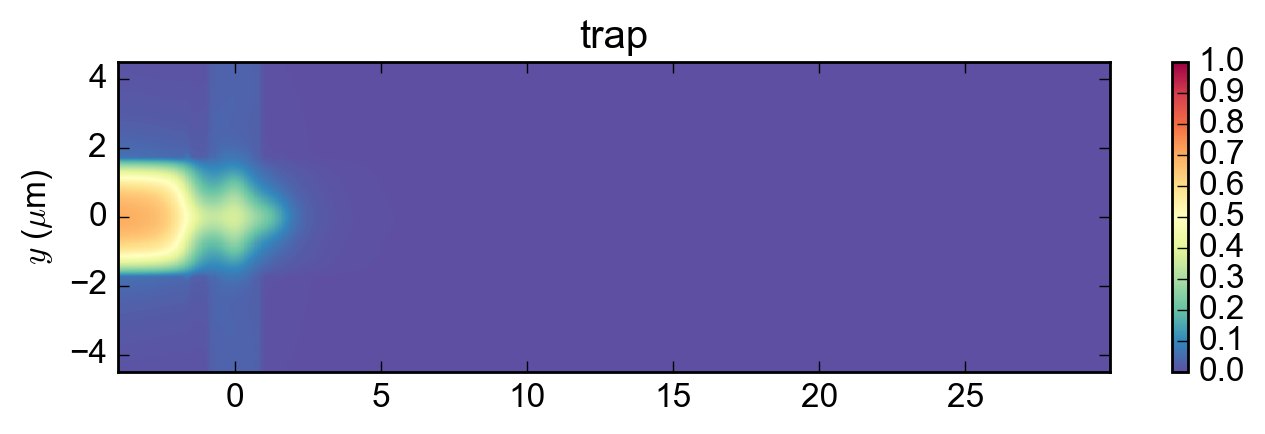

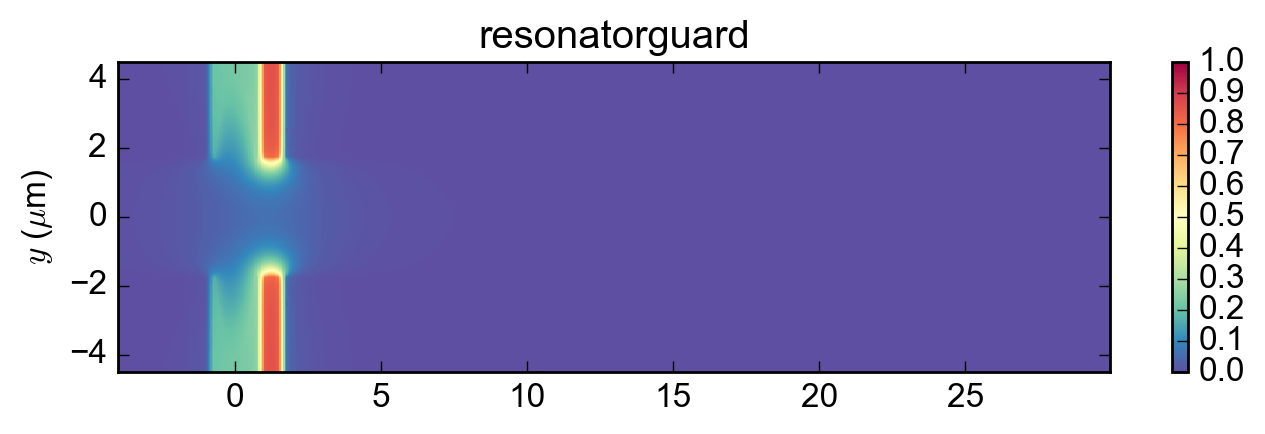

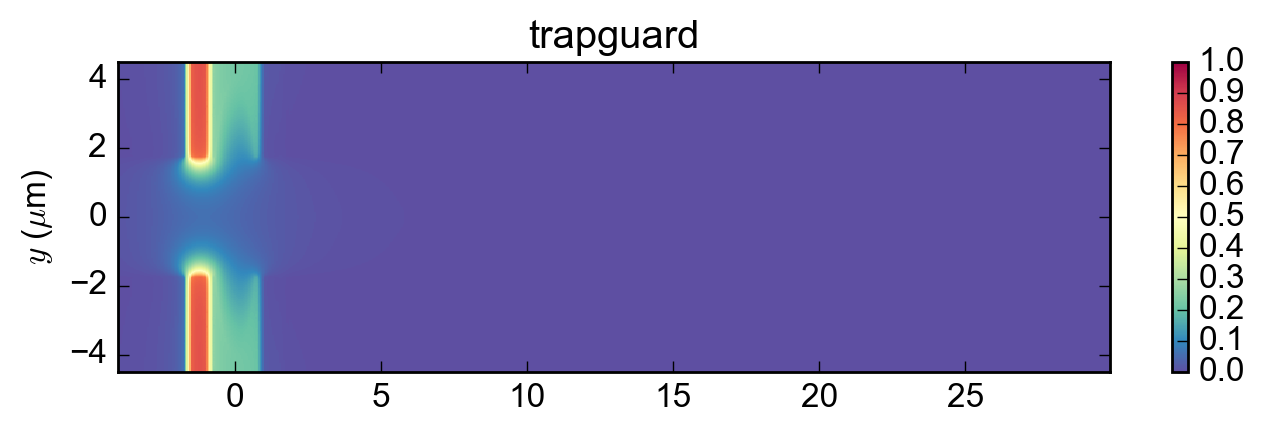

In [14]:
# Evaluate all files in the following range.
xeval = np.linspace(-4.0, 20, 500)
yeval = anneal.construct_symmetric_y(-4.5, 151)

master_path = r"/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/M018V4"
#master_path = r"/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/Greater Trap Area/V1"
x_eval, y_eval, output = anneal.load_data(master_path, xeval=xeval, yeval=yeval, mirror_y=True,
                                          extend_resonator=False, insert_resonator=True, do_plot=True,
                                          inserted_res_length=10)

if 1:
    plt.show()

The difference in depth is 0.0032
This amounts to 0.5%


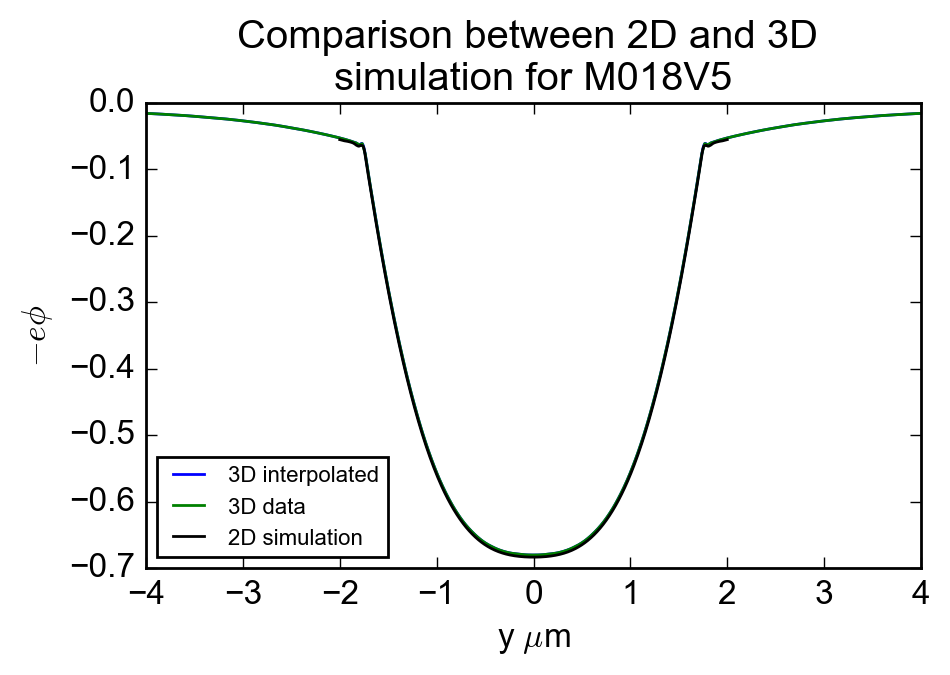

In [72]:
x_oi = 10E-6
x_idx = common.find_nearest(x_eval[0,:], x_oi)
ytest = np.linspace(-4E-6, 4E-6, 1E4)

CMS = anneal.TrapAreaSolver(x_eval[0,:], y_eval[:,0], -output[0]['V'],
                            spline_order_x=3, spline_order_y=3, smoothing=0.00,
                            include_screening=True, screening_length=2*0.74E-6)
fig = plt.figure(figsize = (5.,3.))
common.configure_axes(12)
plt.plot(ytest*1E6, CMS.V(x_oi, ytest), label="3D interpolated")
plt.plot(y_eval[:,0]*1E6, -output[0]['V'][x_idx, :], label="3D data")
plt.plot(x_symmetric, -Uinterp_symmetric, '-k', label="2D simulation")
plt.xlabel("y $\mu$m")
plt.ylabel("$-e \phi$")
plt.legend(loc=0, prop={"size" : 8})
#plt.ylim(-0.69, -0.66)

print("The difference in depth is %.4f"%(np.min(-output[0]['V'][x_idx, :]) - np.min(-Uinterp_symmetric)))
print("This amounts to %.1f%%"\
      %(100 * (np.min(-output[0]['V'][x_idx, :]) - np.min(-Uinterp_symmetric))/np.max(output[0]['V'][x_idx, :])))

plt.xlim(-4, 4)
plt.title("Comparison between 2D and 3D \nsimulation for M018V5")

#common.save_figure(fig, save_path="./Figures")